In [1]:
# 0. Import all libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import seaborn as sns

In [2]:
# 1. Import data
file_path = './data/AAPL.csv'
data = pd.read_csv(file_path)

In [3]:
# 2. Preparing Data
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data.sort_index(ascending=True)

# Subset data for the specified date range
start_date = '2014-06-24'
end_date = '2024-06-21'
data = data[(data.index >= start_date) & (data.index <= end_date)]

In [4]:
# 3. Descriptive statistics
print(data.describe())

              Open         High          Low        Close   Close/Last  \
count  2516.000000  2516.000000  2516.000000  2516.000000  2516.000000   
mean     85.564357    86.484024    84.702970    85.630632    83.597861   
std      58.881674    59.521504    58.293460    58.931788    59.406120   
min      22.500000    22.674999    22.367500    22.570000    19.963961   
25%      32.222499    32.443126    32.039375    32.196249    28.968334   
50%      53.493749    54.152501    52.889149    53.327501    51.340979   
75%     145.057499   146.954998   143.647530   145.525001   143.641334   
max     217.589996   220.199997   213.000000   216.669998   216.669998   

             Volume  
count  2.516000e+03  
mean   1.255896e+08  
std    7.188039e+07  
min    2.404834e+07  
25%    7.656813e+07  
50%    1.062418e+08  
75%    1.542644e+08  
max    7.593850e+08  


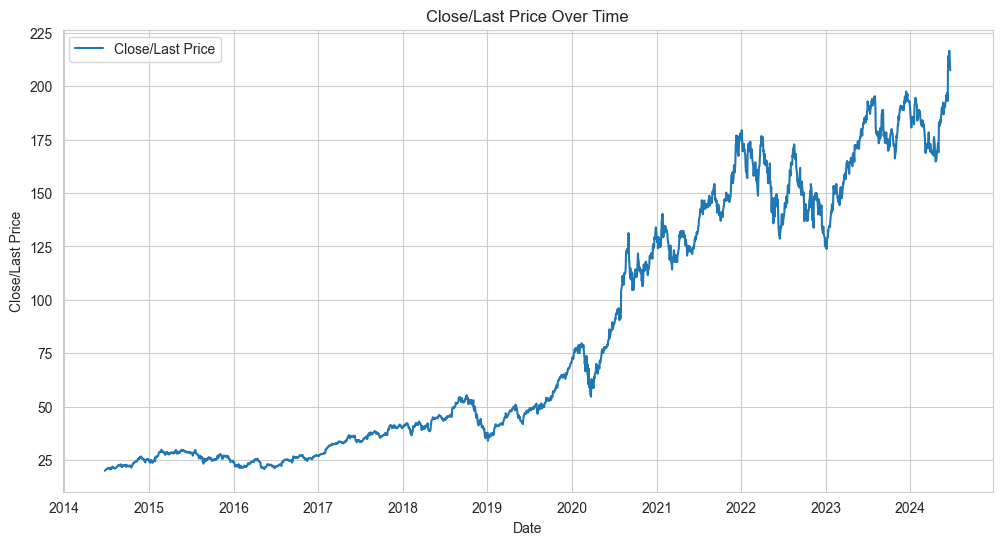

In [5]:
# 4. Visualizing the Close/Last price over time

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close/Last'], label='Close/Last Price')
plt.title('Close/Last Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close/Last Price')
plt.legend()
plt.show()


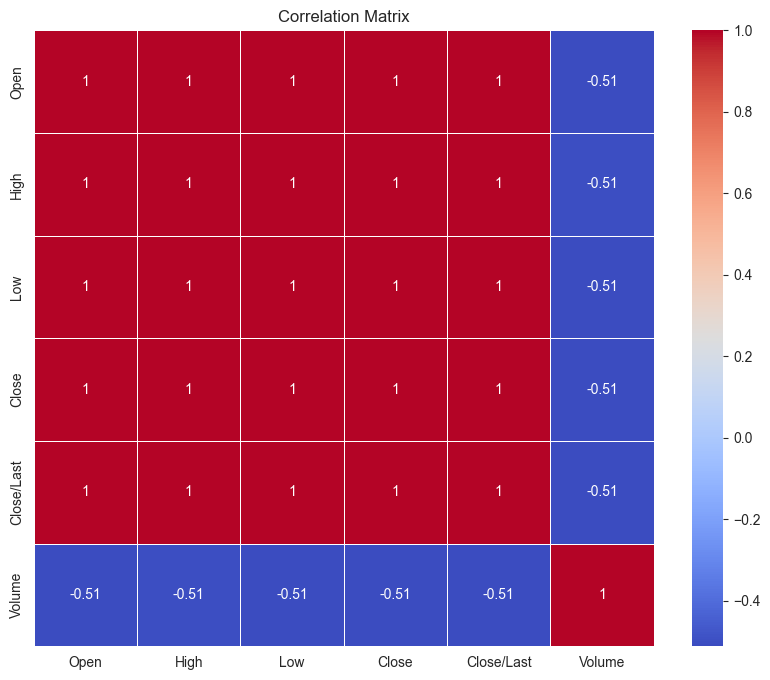

In [6]:
# 5. Correlation

# Correlation matrix
correlation_matrix = data.corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [7]:
# 6. Feature Engineering

# Adding moving averages
data['MA_10'] = data['Close/Last'].rolling(window=10).mean()
data['MA_50'] = data['Close/Last'].rolling(window=50).mean()

# Adding lag features
data['Lag_1'] = data['Close/Last'].shift(1)
data['Lag_5'] = data['Close/Last'].shift(5)
data['Lag_30'] = data['Close/Last'].shift(30)
data['Lag_60'] = data['Close/Last'].shift(60)
data['Lag_90'] = data['Close/Last'].shift(90)

# Drop rows with NaN values (created by rolling and shifting)
data.dropna(inplace=True)


<Figure size 1200x600 with 0 Axes>

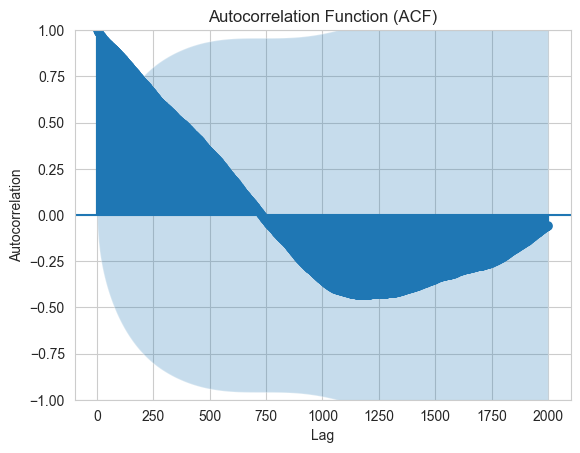

In [20]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

# 计算自相关函数（ACF）
plt.figure(figsize=(12, 6))
plot_acf(data['Close/Last'], lags=2000)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

In [18]:

# 计算自相关系数
acf_values = acf(data['Close/Last'], nlags=100)

# 打印特定滞后期的自相关系数
print(f"Lag 30: {acf_values[30]}")
print(f"Lag 60: {acf_values[60]}")
print(f"Lag 90: {acf_values[90]}")


Lag 30: 0.9498071676353553
Lag 60: 0.913236997849941
Lag 90: 0.878163078361425


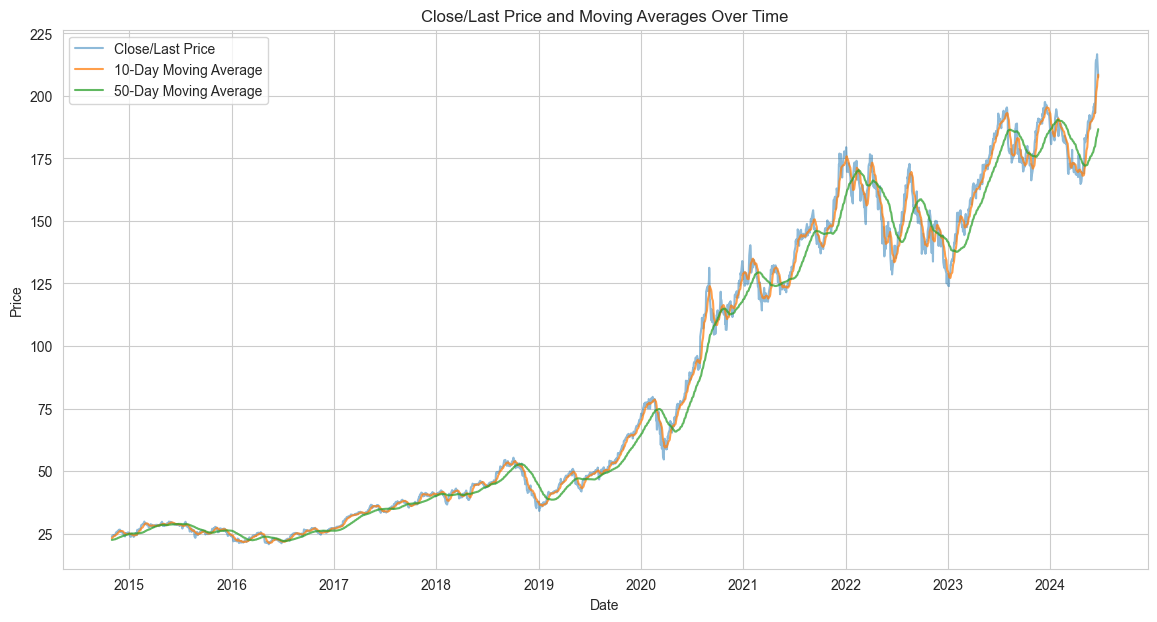

In [8]:
# 6.1  Plotting the Close/Last price with moving averages
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close/Last'], label='Close/Last Price', alpha=0.5)
plt.plot(data.index, data['MA_10'], label='10-Day Moving Average', alpha=0.75)
plt.plot(data.index, data['MA_50'], label='50-Day Moving Average', alpha=0.75)
plt.title('Close/Last Price and Moving Averages Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


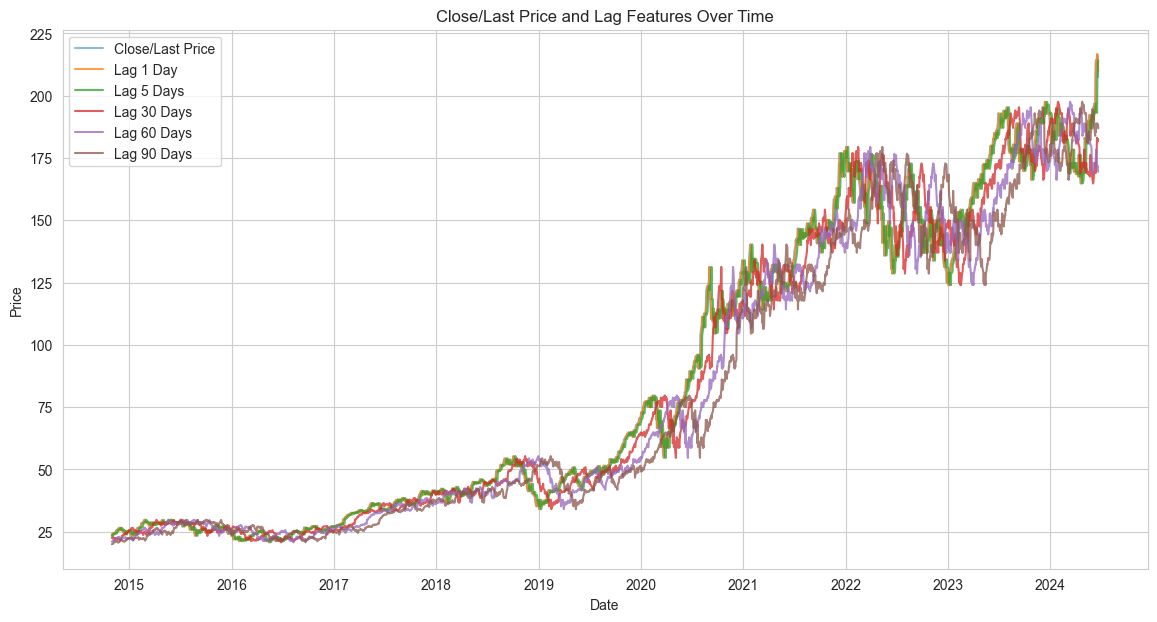

In [9]:
# 6.2 Plotting the Close/Last price with lag features
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close/Last'], label='Close/Last Price', alpha=0.5)
plt.plot(data.index, data['Lag_1'], label='Lag 1 Day', alpha=0.75)
plt.plot(data.index, data['Lag_5'], label='Lag 5 Days', alpha=0.75)
plt.plot(data.index, data['Lag_30'], label='Lag 30 Days', alpha=0.75)
plt.plot(data.index, data['Lag_60'], label='Lag 60 Days', alpha=0.75)
plt.plot(data.index, data['Lag_90'], label='Lag 90 Days', alpha=0.75)
plt.title('Close/Last Price and Lag Features Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


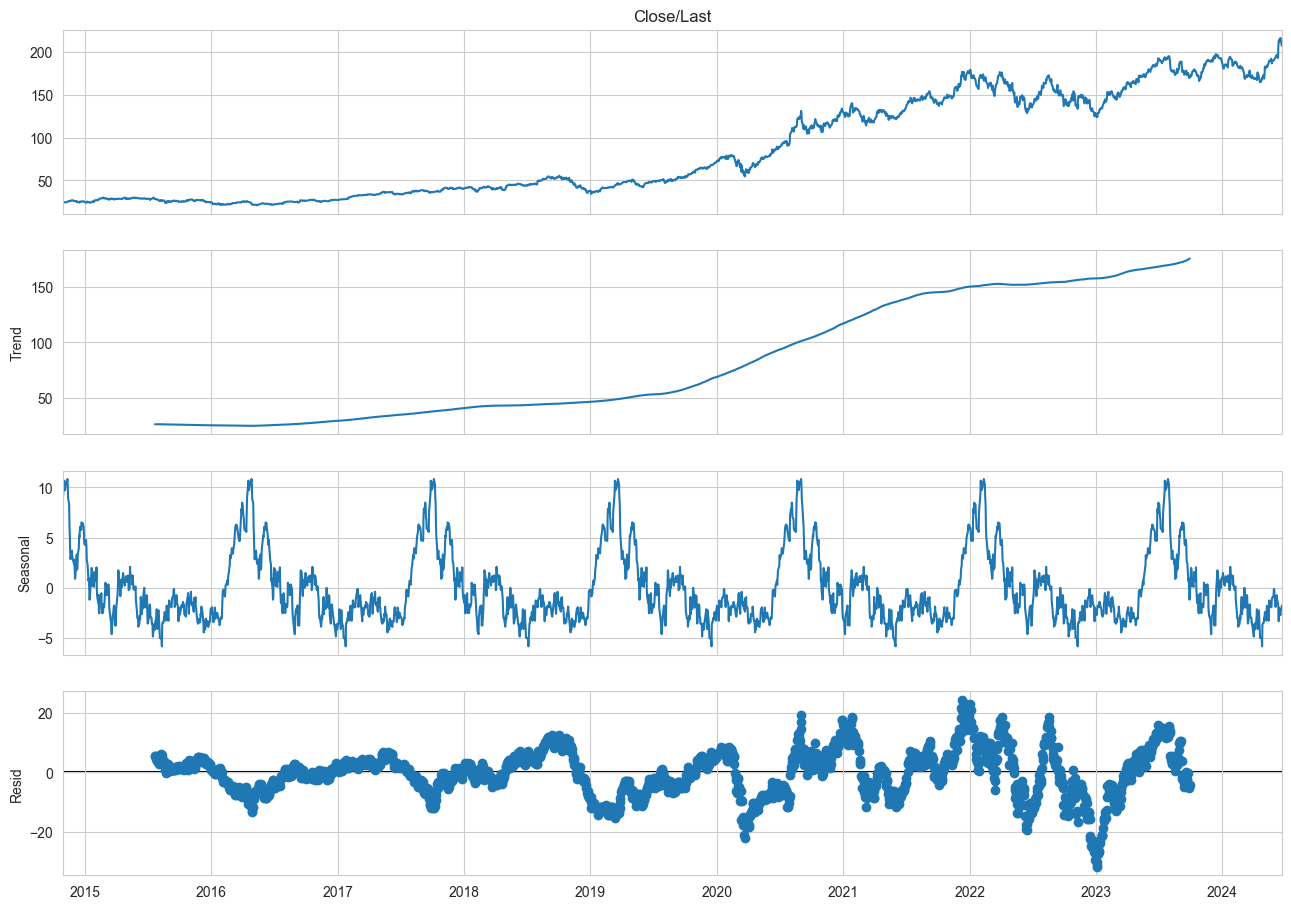

In [10]:
import statsmodels.api as sm

# 7. Decompose the time series to observe trend, seasonality, and residuals
decomposition = sm.tsa.seasonal_decompose(data['Close/Last'], model='additive', period=365)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()


In [11]:
# Save each component to a DataFrame
trend_df = pd.DataFrame({'Date': trend.index, 'Trend': trend.values}).dropna()
seasonal_df = pd.DataFrame({'Date': seasonal.index, 'Seasonal': seasonal.values}).dropna()
residual_df = pd.DataFrame({'Date': residual.index, 'Residual': residual.values}).dropna()

# # Print the first few rows of each DataFrame
# print("Trend DataFrame:")
# print(trend_df.head())
# print("\nSeasonal DataFrame:")
# print(seasonal_df.head())
# print("\nResidual DataFrame:")
# print(residual_df.head())

In [12]:
# 7.1 Trend Component: Calculate the slope
trend.dropna(inplace=True)  # Drop NaN values
X = np.arange(len(trend)).reshape(-1, 1)
y = trend.values
model = LinearRegression().fit(X, y)
slope = model.coef_[0]
print(f"Trend Slope: {slope}")

# 7.2 Seasonal Component: Calculate the amplitude
seasonal_max = seasonal.max()
seasonal_min = seasonal.min()
amplitude = seasonal_max - seasonal_min
print(f"Seasonal Amplitude: {amplitude}")

# 7.3 Residual Component: Calculate the standard deviation
residual_std = residual.std()
print(f"Residual Standard Deviation: {residual_std}")

Trend Slope: 0.08530128776344974
Seasonal Amplitude: 16.67157560684932
Residual Standard Deviation: 7.756050914293265


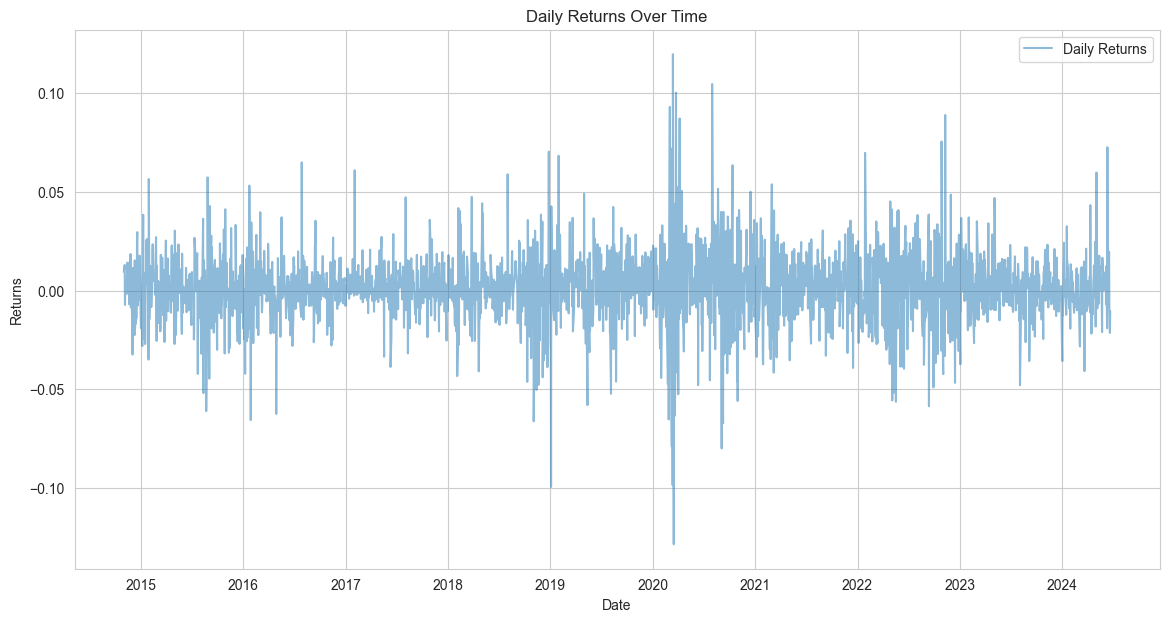

In [13]:
# Calculate the daily returns
data['Daily_Returns'] = data['Close/Last'].pct_change()

# Plotting the daily returns
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Daily_Returns'], label='Daily Returns', alpha=0.5)
plt.title('Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()


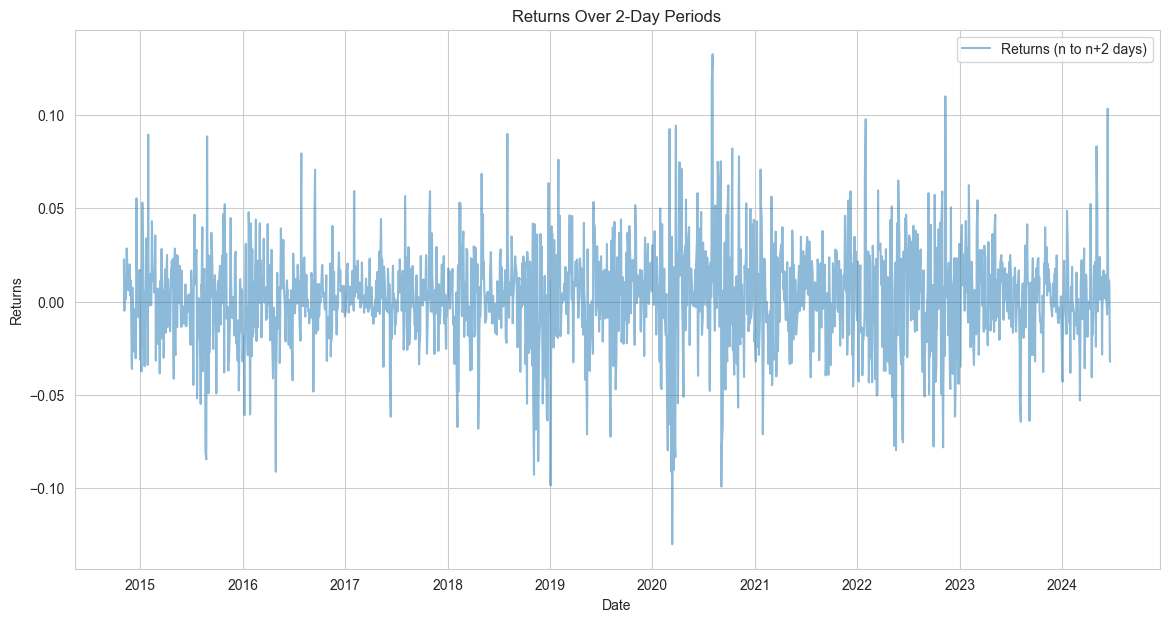

In [14]:
# Calculate the returns between n and n+2 days
data['Returns_n_to_n+2'] = data['Close/Last'].pct_change(periods=2)

# Plotting the n to n+2 day returns
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Returns_n_to_n+2'], label='Returns (n to n+2 days)', alpha=0.5)
plt.title('Returns Over 2-Day Periods')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

Returns (n to n+10 days) Metrics:
Mean Return: 0.01182894164486424
Standard Deviation: 0.05486705951647481
Annualized Return: 18.36371006138803
Sharpe Ratio: 3.422429210664237

Returns (n to n+30 days) Metrics:
Mean Return: 0.0358368997135214
Standard Deviation: 0.09972349166872575
Annualized Return: 7134.546213607322
Sharpe Ratio: 5.704705449936099

Returns (n to n+365 days) Metrics:
Mean Return: 0.4668585319720917
Standard Deviation: 0.46081977125526374
Annualized Return: 8.508133153858667e+41
Sharpe Ratio: 16.082533564246365


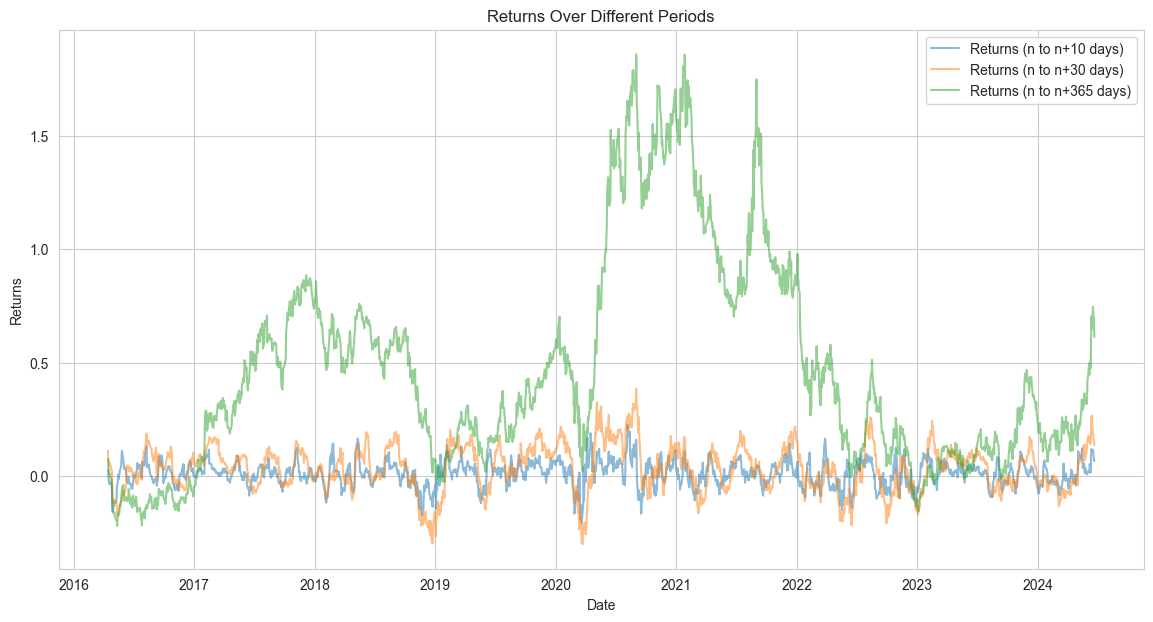

In [15]:
# Calculate returns for different periods
data['Returns_n_to_n+10'] = data['Close/Last'].pct_change(periods=10)
data['Returns_n_to_n+30'] = data['Close/Last'].pct_change(periods=30)
data['Returns_n_to_n+365'] = data['Close/Last'].pct_change(periods=365)

# Drop NaN values
data.dropna(inplace=True)

# Define a function to calculate performance metrics
def calculate_performance_metrics(returns, risk_free_rate=0.0):
    mean_return = returns.mean()
    std_dev = returns.std()
    annualized_return = ((1 + mean_return) ** 252) - 1  # Assuming 252 trading days in a year
    sharpe_ratio = (mean_return - risk_free_rate) / std_dev * np.sqrt(252)
    
    return {
        "Mean Return": mean_return,
        "Standard Deviation": std_dev,
        "Annualized Return": annualized_return,
        "Sharpe Ratio": sharpe_ratio
    }

# Calculate metrics for n to n+10 day returns
n_to_n_plus_10_metrics = calculate_performance_metrics(data['Returns_n_to_n+10'])

# Calculate metrics for n to n+30 day returns
n_to_n_plus_30_metrics = calculate_performance_metrics(data['Returns_n_to_n+30'])

# Calculate metrics for n to n+365 day returns
n_to_n_plus_365_metrics = calculate_performance_metrics(data['Returns_n_to_n+365'])

# Print the performance metrics
print("Returns (n to n+10 days) Metrics:")
for key, value in n_to_n_plus_10_metrics.items():
    print(f"{key}: {value}")

print("\nReturns (n to n+30 days) Metrics:")
for key, value in n_to_n_plus_30_metrics.items():
    print(f"{key}: {value}")

print("\nReturns (n to n+365 days) Metrics:")
for key, value in n_to_n_plus_365_metrics.items():
    print(f"{key}: {value}")

# Plotting the returns for visualization
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Returns_n_to_n+10'], label='Returns (n to n+10 days)', alpha=0.5)
plt.plot(data.index, data['Returns_n_to_n+30'], label='Returns (n to n+30 days)', alpha=0.5)
plt.plot(data.index, data['Returns_n_to_n+365'], label='Returns (n to n+365 days)', alpha=0.5)
plt.title('Returns Over Different Periods')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

In [16]:
data

,Open,High,Low,Close,Close/Last,Volume,MA_10,MA_50,Lag_1,Lag_5,Lag_30,Lag_60,Lag_90,Daily_Returns,Returns_n_to_n+2,Returns_n_to_n+10,Returns_n_to_n+30,Returns_n_to_n+365
Date,,,,,,,,,,,,,,,,,,
2016-04-14,27.905001,28.097500,27.832500,28.025000,25.584812,101895692,25.166695,23.371238,25.571123,24.772306,22.994379,21.941843,26.150436,0.000535,0.015030,0.028535,0.112655,0.076142
2016-04-15,28.027500,28.075001,27.432501,27.462500,25.071291,187755876,25.163500,23.435234,25.584812,24.799702,23.165552,21.971359,27.019846,-0.020071,-0.019547,-0.001273,0.082266,0.044583
2016-04-18,27.222500,27.237499,26.735001,26.870001,24.530386,243285844,25.080423,23.484898,25.071291,24.881865,23.510189,21.860125,26.849588,-0.021575,-0.041213,-0.032757,0.043394,0.008967
2016-04-19,26.969999,27.000000,26.557501,26.727501,24.400290,129539516,25.014236,23.543736,24.530386,25.205956,23.250002,23.022367,26.838247,-0.005303,-0.026764,-0.026409,0.049475,0.011009
2016-04-20,26.660000,27.022499,26.514999,26.782499,24.450500,122444120,24.926823,23.599059,24.400290,25.571123,23.058283,22.572912,26.245777,0.002058,-0.003257,-0.034517,0.060378,0.010670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-14,213.850006,215.169998,211.300003,212.490005,212.490005,70122748,201.569000,183.242010,214.240005,196.889999,172.795624,178.427994,188.802673,-0.008168,-0.002722,0.105280,0.229719,0.648892
2024-06-17,213.369995,218.949997,212.720001,216.669998,216.669998,93728300,203.833000,184.188404,212.490005,193.119995,183.131607,171.137878,188.912399,0.019671,0.011342,0.116683,0.183138,0.746662
2024-06-18,217.589996,218.630005,213.000000,214.289993,214.289993,79943254,205.826999,185.109767,216.669998,207.149994,181.463882,172.046646,187.825256,-0.010984,0.008471,0.102598,0.180896,0.709840


============

In [ ]:

train_set = data[(data['Date'] >= '2014-06-24') & (data['Date'] < '2023-06-24')].copy()
valid_set = data[(data['Date'] >= '2022-06-25') & (data['Date'] <= '2024-06-21')].copy()

# # Split data
# total_length = len(data)
# train_length = int(total_length * 0.70)
# train_set = data.iloc[:train_length].copy()
# valid_set = data.iloc[train_length:].copy()


In [7]:
# 2. Setup Variables
# 2.1 Time horizon set to be 9 years for training, 1 year for validation
# 2.2 time steps for LSTM
time_steps = 60     # tested [30, 60, 90, 120], 90 is the most efficient one

In [8]:
# 3. Data pre-processing
scaler = MinMaxScaler(feature_range=(0, 1))

# Normalize the 'Close/Last' column for both training and validation sets
train_data = scaler.fit_transform(train_set['Close/Last'].values.reshape(-1, 1))
valid_data = scaler.transform(valid_set['Close/Last'].values.reshape(-1, 1))

# Initialize lists to store training and validation data
x_train, y_train = [], []
for i in range(time_steps, len(train_data)):
    x_train.append(train_data[i-time_steps:i, 0])
    y_train.append(train_data[i, 0])

x_valid, y_valid = [], []
for i in range(time_steps, len(valid_data)):
    x_valid.append(valid_data[i-time_steps:i, 0])
    y_valid.append(valid_data[i, 0])

# Convert lists to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_valid, y_valid = np.array(x_valid), np.array(y_valid)
x_valid = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1], 1))


In [9]:
# 4. Build Model - function
def build_model():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


# def build_model():
#     model = Sequential()
#     model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, 1)))
#     model.add(Dropout(0.2))
#     model.add(LSTM(units = 50, return_sequences = True))
#     model.add(Dropout(0.2))
#     model.add(LSTM(units = 50, return_sequences = True))
#     model.add(Dropout(0.2))
#     model.add(LSTM(64, input_shape=(64,32,16), return_sequences=False))
#     model.add(Dropout(0.2))
#     #model.add(LSTM(units = 50))
#     model.add(Dropout(0.2))
#     model.add(Dense(1, activation='linear'))
#     model.add(Dense(units = 1))
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model


In [10]:
# 5. Training - Function
def train_model(model, x_train, y_train):
    model.fit(x_train, y_train, epochs=25, batch_size=32)


In [11]:
# 6. Make Prediction - Function
def make_prediction(model, x_valid, scaler):
    predicted_y_valid_normalized = model.predict(x_valid)
    predicted_y_valid = scaler.inverse_transform(predicted_y_valid_normalized)
    return predicted_y_valid

In [12]:
# Execute step 4,5,6
model = build_model()
train_model(model, x_train, y_train)
predicted_y_valid = make_prediction(model, x_valid, scaler)

Epoch 1/25


/Users/beilinye/Desktop/Spring_2024/SYDE_660a/6_Code/stock-prediction/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0053
Epoch 2/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.0430e-04
Epoch 3/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.7015e-04
Epoch 4/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.0906e-04
Epoch 5/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.1063e-04
Epoch 6/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 6.5598e-04
Epoch 7/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.7831e-04
Epoch 8/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.6056e-04
Epoch 9/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.1883e-04
Epoch 10/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.9984e-04
Epoch 11/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.3850e-04
Epoch 12/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.0244e-04
Epoch 13/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.7516e-04
Epoch 14/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.4833e-04
Epoch 15/25
69/69 ━━━━━━━━━━━━

LSTM RMSE on validation set: 137.58536015912017


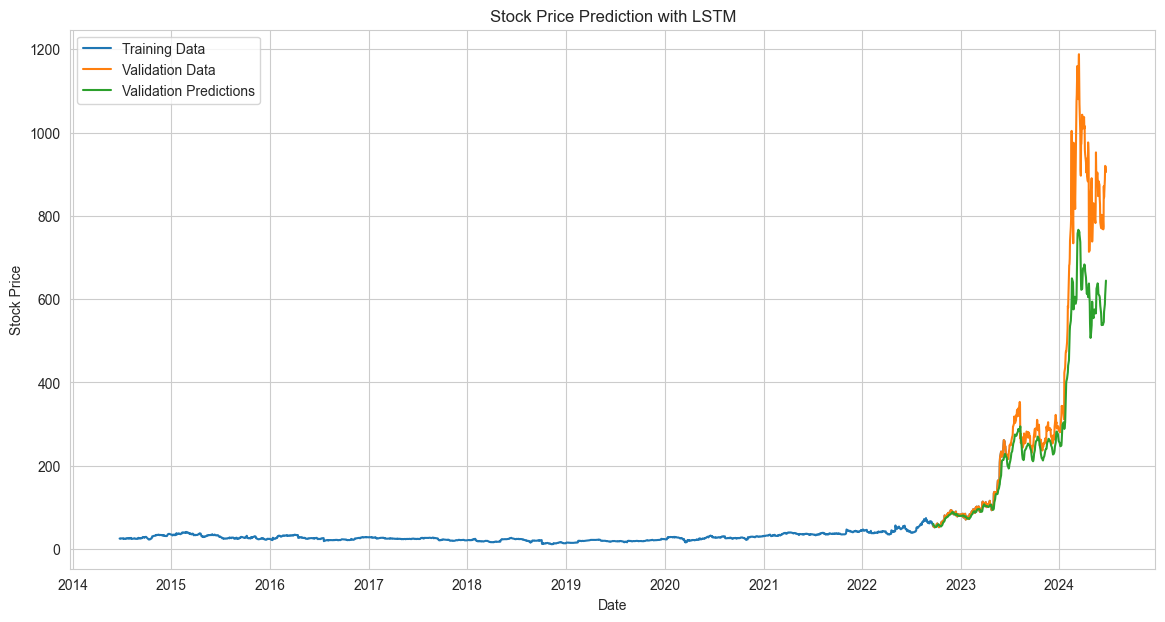

In [13]:
# 7. Print & Visualize the results
valid_rmse = np.sqrt(mean_squared_error(valid_set['Close/Last'].values[time_steps:], predicted_y_valid))
print(f"LSTM RMSE on validation set: {valid_rmse}")

plt.figure(figsize=(14, 7))
plt.plot(train_set['Date'], train_set['Close/Last'], label='Training Data')
plt.plot(valid_set['Date'][time_steps:], valid_set['Close/Last'].values[time_steps:], label='Validation Data')
plt.plot(valid_set['Date'][time_steps:], predicted_y_valid, label='Validation Predictions')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction with LSTM')
plt.legend()
plt.show()